## GOOD TO KNOW

Lasso Regression is a smart version of Linear Regression that automatically decides which features are important. It adds a penalty to the model so that less useful features get their coefficients shrunk to 0, effectively removing them. They act as the 'Feature Selector' built into regression.

Linear Regression tries to minimise MSE - Mean squared error.
Lasso Regression minimizes (error + penalty term) based on the L1 regularization - absolute value of coefficients. 
SO if larger coefficients then higher penalty
Not so important features for which coefficients becomes 0
Our model will be simplified and possibly avoidin overfitting (we have many correlated/noisy predictors like lag features, rolling average)

Metrics: MAE, MSE, R2Score

## DATA PREPARATION
In continuation to Linear Regression where train/test/y-pred all done with cyclical date encodings, lag features, rolling mean etc. and forecating with the lagfeatures only,

Here, Lasso Regression is trained using the all engineered features. The test set also uses all these same features to validate the model performance.
During Forecasting, we only have lag based inputs as the future values of rainfall, wind etc are unknown.

The model learned patterns that link recent lags and trends to the next day temp. Even without the other features, the model can make reasonable extrapolation using these lagged inputs.

## FEATURE IMPORTANCE CHART - VIZ 2
We will also be visualizing the coefficients in Lasso Regression.
Lasso - L1 Regularization - more than just fitting a line, it shrinks some coefficients exactly to 0

A coef plot shows which feature have the most influence on temperature prediction and which are effectively ignored (coef=0)

Features that

INCREASE prediction - large POSITIVE coefficients

DECREASE prediction - large NEGATIVE coefficients

Lasso DROPPED as unimportant = ZERO coefficients

This visualization is going to be the Lasso's built in feature importance chart.
With respect to our model, we visualize coefficients in Lasso to understand which features truly drive the forecase and which are the model deems irrelvant.

In [1]:
#REUSABLE CODE PATH CONFIGURATION
import sys, os
sys.path.append(r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction")
import utils

## LASSO REGRESSION

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [3]:
x_train, y_train, x_test, y_test = utils.load_data()
print(x_train.shape, 
      y_train.shape, x_test.shape, y_test.shape)

lasso_scaler = utils.load_scaler()
x_train_scaled = lasso_scaler.fit_transform(x_train.drop(columns=["date"], errors="ignore"))
x_test_scaled = lasso_scaler.transform(x_test.drop(columns=["date"], errors ="ignore"))

x_train_scaled_df = pd.DataFrame(x_train_scaled, 
                                 columns = x_train.drop(columns=["date"], errors = "ignore").columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, 
                                columns=x_test.drop(columns=["date"], errors ="ignore").columns)
print("Before:", y_train.shape)
print("Before:", y_test.shape)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("After:", y_train.shape)
print("After: ", y_test.shape)

(3154, 17) (3154, 1) (789, 17) (789, 1)
Before: (3154, 1)
Before: (789, 1)
After: (3154,)
After:  (789,)


## MODEL CREATION AND SAVE

In [4]:
lasso_l1 = Lasso(alpha = 0.1, random_state=42)
lasso_l1.fit(x_train_scaled_df, y_train)
utils.save_model(lasso_l1, "lasso_regression")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\lasso_regression.pkl


lasso_regression Model Evaluation starts...
predicting with lasso_regression...
Calculating Metrics...
Visualizing lasso_regression...


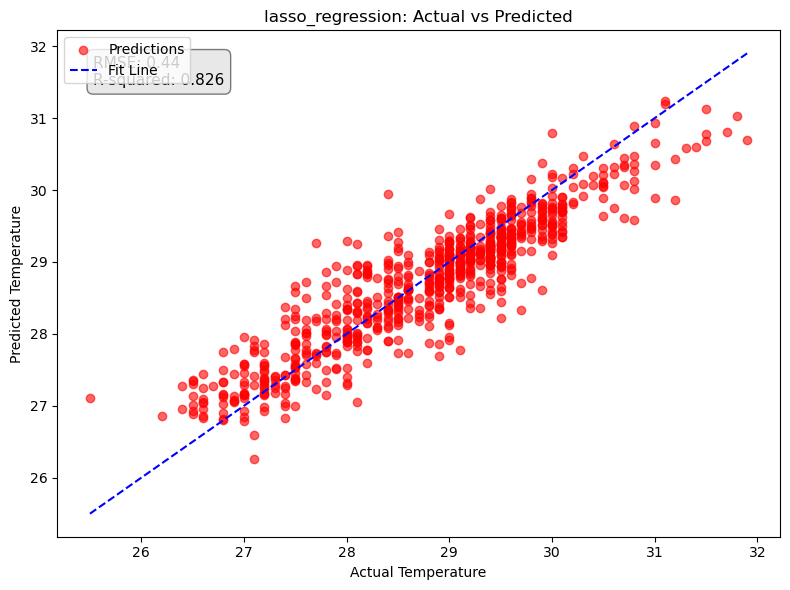

lasso_regression - Visualization - 1 done


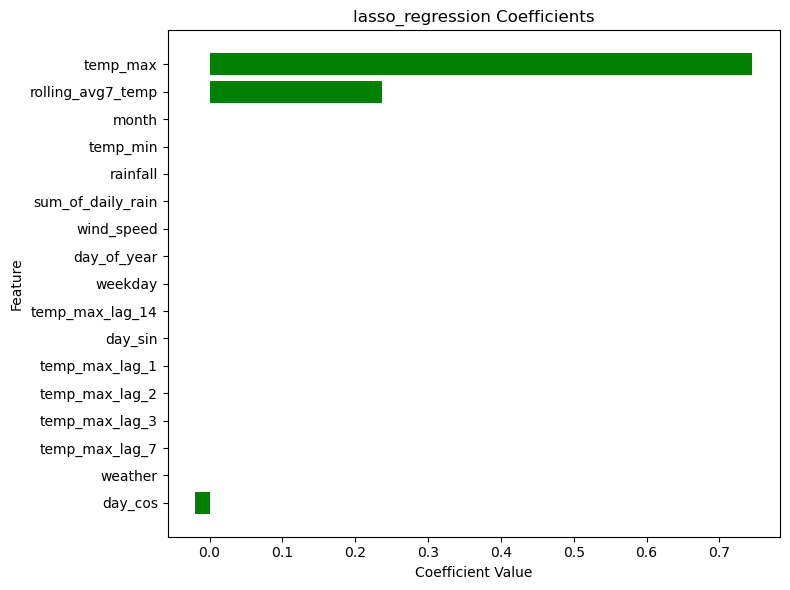

lasso_regression - Visualization -2 done
RMSE: 0.43769829743298816, 
r2 score:0.826


In [5]:
rmse, r2 = utils.evaluate_model(x_test_scaled_df, y_test, "lasso_regression")
print(f"RMSE: {rmse}, \nr2 score:{r2:.3f}")

## LASSO CV REGRESSOR

Low alpha 0.001 - very little regularization

This will behave almost like linear regression and may overfit - high variance

High alpha 10 - a string penaly and shrinks many coefficients to 0. and may underfit - high bias

Now Lasso model that balances bias and variance and we want to find that sweet spot.
So we are employing CV technique to find the best alpha from a range.


In [6]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
"""
generating 50 alpha values spaced logarithmically between 10^-3(0.001)(-3 in logscale) 
and 10^2 (100) (2 in logscale)
1 - 0.001 - almost no regularization (behaves like Linear Regression)
10 - 0.01 - light regularization
25 - 1.0 - moderate regularization
40 - 10 - strong regularization
50 - 100 - very strong regularization (many coefficients forced to zero
regularization strength often behaves exponentially so a slight change near 0 can make a big impact
"""
alphas = np.logspace(-3,2, 50)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state = 42)
#cv=5 fold is computationally light as our data is not huge, so we can find our right alpha value
lasso_cv.fit(x_train_scaled_df, y_train)

#Getting the best alpha
print("Best alpha: ", lasso_cv.alpha_)

Best alpha:  0.002559547922699536


In [8]:
lasso_cv.alphas_

array([1.00000000e+02, 7.90604321e+01, 6.25055193e+01, 4.94171336e+01,
       3.90693994e+01, 3.08884360e+01, 2.44205309e+01, 1.93069773e+01,
       1.52641797e+01, 1.20679264e+01, 9.54095476e+00, 7.54312006e+00,
       5.96362332e+00, 4.71486636e+00, 3.72759372e+00, 2.94705170e+00,
       2.32995181e+00, 1.84206997e+00, 1.45634848e+00, 1.15139540e+00,
       9.10298178e-01, 7.19685673e-01, 5.68986603e-01, 4.49843267e-01,
       3.55648031e-01, 2.81176870e-01, 2.22299648e-01, 1.75751062e-01,
       1.38949549e-01, 1.09854114e-01, 8.68511374e-02, 6.86648845e-02,
       5.42867544e-02, 4.29193426e-02, 3.39322177e-02, 2.68269580e-02,
       2.12095089e-02, 1.67683294e-02, 1.32571137e-02, 1.04811313e-02,
       8.28642773e-03, 6.55128557e-03, 5.17947468e-03, 4.09491506e-03,
       3.23745754e-03, 2.55954792e-03, 2.02358965e-03, 1.59985872e-03,
       1.26485522e-03, 1.00000000e-03])

In [9]:
#using the aloha now,
lasso_model1 = Lasso(alpha = lasso_cv.alpha_, random_state= 42)
lasso_model1.fit(x_train_scaled_df, y_train)
utils.save_model(lasso_model1, "lassoCV")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\lassoCV.pkl


## LassoCV Alpha Tuning Curve 
## CV Error vs Regularization Strength

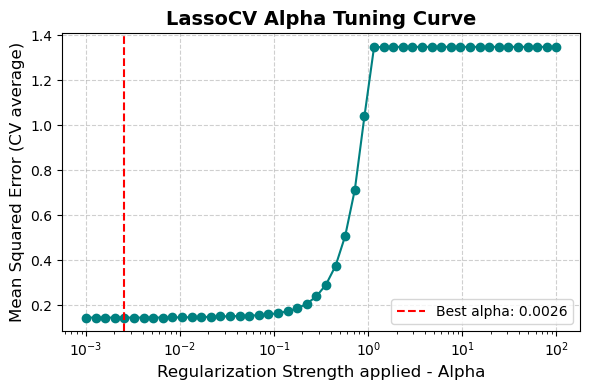

In [10]:
all_alphas = lasso_cv.alphas_
mse_path =lasso_cv.mse_path_.mean(axis=1)#avg MSE across folds
plt.figure(figsize=(6,4))
plt.plot(all_alphas, mse_path, marker = "o", color="teal")
plt.axvline(lasso_cv.alpha_, color='red',linestyle='--', label=f"Best alpha: {lasso_cv.alpha_:.4f}")
plt.xscale("log")
plt.xlabel("Regularization Strength applied - Alpha" ,fontsize=12)
plt.ylabel("Mean Squared Error (CV average)", fontsize=12)
plt.title("LassoCV Alpha Tuning Curve", fontsize=14, weight="bold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## LASSO CV CROSS VALIDATION ERROR CURVE
## Plotting MSE per fold 

helps us to see how consistent our model's performance was across our cross validation splits.


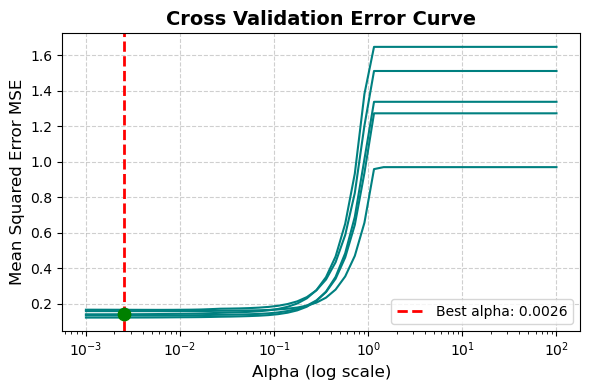

In [11]:
#get n_alphas and n_folds with mse_path
mse_path = lasso_cv.mse_path_
alphas = lasso_cv.alphas_

mean_mse= np.mean(mse_path, axis=1)
std_mse = np.std(mse_path, axis=1)
best_alpha = lasso_cv.alpha_

plt.figure(figsize=(6,4))
#plotting MSE for every fold
plt.plot(alphas, mse_path, color='teal')

#plotting mean MSE with error band
plt.axvline(best_alpha, color='red', linestyle='--', linewidth = 2, 
           label=f"Best alpha: {lasso_cv.alpha_:.4f}")#adding vertical line across the axis of the plot to hightlight th x-axis
plt.scatter(best_alpha, np.min(mean_mse), color='green', s=80, zorder = 5) # s-marker size, zorder - controls the drawing order
#with this we can see the optimal alpha value that gave the lowest error during the model training.

plt.xscale("log")
plt.xlabel("Alpha (log scale)", fontsize=12)
plt.ylabel("Mean Squared Error MSE", fontsize =12)
plt.title("Cross Validation Error Curve", fontsize=14, weight = "bold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## MODEL EVALUATION AND MODEL METRICS

lassoCV Model Evaluation starts...
predicting with lassoCV...
Calculating Metrics...
Visualizing lassoCV...


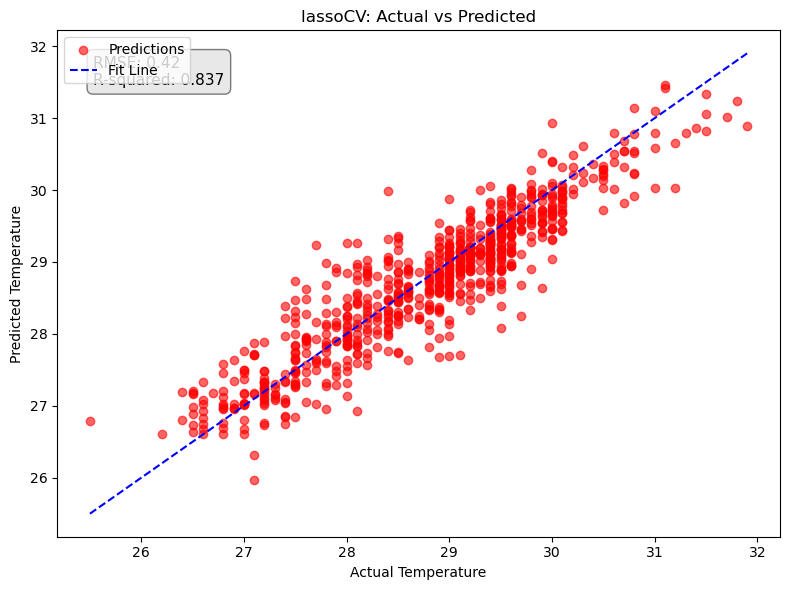

lassoCV - Visualization - 1 done


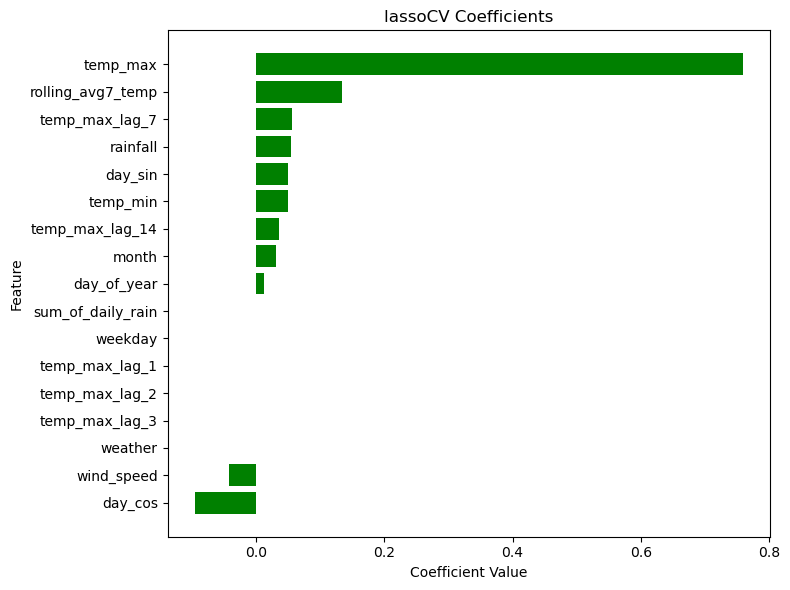

lassoCV - Visualization -2 done
RMSE: 0.4228880503863318, 
r2 score:0.837


In [12]:
rmse, r2 = utils.evaluate_model(x_test_scaled_df, y_test, "lassoCV")
print(f"RMSE: {rmse}, \nr2 score:{r2:.3f}")

The viz 2 displacys the Lasso CV coefficients.

x-axis coefficients:

+ve - direct(increasing) relationship with our target max_temp

-ve - inverse(decreasing) relationship with our target

near 0 - the model considered them unimportant.

## METRICS BETWEEN LASSO and LASSO CV

LassoCV
RMSE: 0.42293389283484883, 
r2 score:0.837

Lasso
RMSE: 0.4377435667769344, 
r2 score:0.826

With RMSE which is 0.42 for LassoCV and 0.43 for Lasso.
We have low RMSE that is 0.42 with LassoCV which is an improvement over Lasso's 0.43
Lower the better. so LassoCV is a slightly better fit

With R2 which is 0.837 meaning ~83.7 of variance explained by LassoCV
and R2 0.826 meaning ~82.6 of variance explained by Lasso
Higher the better so LassoCV explains slightly a higher level of variance.

Thus Cross Validation helped automatically tune the alpha to balance bias-variance tradeoff

## FORECAST

In [13]:
forecast_results = utils.forecast_next_3_days("lassoCV",x_test_scaled_df, 3)
print(forecast_results)

Last Date:  2025-11-01 23:30:58.065621
Next Day:  2025-11-02 23:30:58.065621
Next Day:  2025-11-03 23:30:58.065621
Next Day:  2025-11-04 23:30:58.065621
         date  predicted_temp
0  2025-11-02           28.87
1  2025-11-03           28.84
2  2025-11-04           28.86


In [14]:
forecast_results1 = utils.forecast_next_3_days("lasso_regression",x_test_scaled_df, 3)
print(forecast_results1)

Last Date:  2025-11-01 23:30:58.095503
Next Day:  2025-11-02 23:30:58.095503
Next Day:  2025-11-03 23:30:58.095503
Next Day:  2025-11-04 23:30:58.095503
         date  predicted_temp
0  2025-11-02           28.82
1  2025-11-03           28.82
2  2025-11-04           28.82
